In [1]:
from read_utils import read_tables
import pickle

import pathlib as pl
import pandas as pd
import numpy as np

import scipy  # to perform Mann-Whitney U Test
from cliffsDelta import cliffsDelta  # to estimate effect size by Cliff's Delta

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
from matplotlib.ticker import FuncFormatter

import seaborn as sns
sns.set_theme(style="whitegrid")

## Define paths.

In [2]:
# Inputs.
# data_dir = pl.Path('../data')
processed_data_dir = pl.Path('../processed_data')
log_features_file = processed_data_dir.joinpath(
    'log_features/justhink19_log_features_task_level.csv')
learning_file = processed_data_dir.joinpath(
    'learning_features/justhink19_learning_features.csv')


annot_corpus_dir = processed_data_dir.joinpath('annotated_corpus')
annot_corpus_pickle_file = annot_corpus_dir.joinpath(
    'justhing19_annotated_corpus.pickle')

routines_dir = processed_data_dir.joinpath('routines')

# Outputs.
plots_dir = pl.Path('../figures')


# Create output directories if they do not exist.
for folder in [plots_dir]:
    if not folder.exists():
        folder.mkdir(parents=True)

## Load data.

### Read learning data.

In [3]:
learning_df = pd.read_csv(learning_file, index_col='team_no')

# learning_df

### Read task features data (at the team level).

In [4]:
task_df = pd.read_csv(log_features_file, index_col='team_no')

# task_df

### Read annotated corpus (of dialogue and actions).

In [5]:
with annot_corpus_pickle_file.open('rb') as handle:
    corpus_dfs = pickle.load(handle)

### Read routine tables.

In [6]:
routine_dfs = read_tables(routines_dir, form='routine')

# routines_dfs[7].head() #['utterance_no_list']

Reading routine files from ../processed_data/routines.
routine 10 files found.
File justhink19_routines_07 belongs to team  7
File justhink19_routines_08 belongs to team  8
File justhink19_routines_09 belongs to team  9
File justhink19_routines_10 belongs to team 10
File justhink19_routines_11 belongs to team 11
File justhink19_routines_17 belongs to team 17
File justhink19_routines_18 belongs to team 18
File justhink19_routines_20 belongs to team 20
File justhink19_routines_28 belongs to team 28
File justhink19_routines_47 belongs to team 47


## Construct task success tables.

### Prepare a learning outcomes table.

In [7]:
df = learning_df[['RLG', 'A_pretest', 'A_posttest', 'B_pretest', 'B_posttest']].copy()
df = df[df.index.isin(corpus_dfs.keys())]
df.insert(0, 'learn (%)', 100*df['RLG'])
df = df.drop(['RLG'], axis=1)
df.index.name = 'Team No'
for prefix in ['pretest', 'posttest']:
    df['{}s'.format(prefix)] = [
        '{:3.0f},{:3.0f}'.format(
            100*df.loc[t]['A_{}'.format(prefix)],
            100*df.loc[t]['B_{}'.format(prefix)])
        for t in df.index]
df = df[['learn (%)', 'pretests', 'posttests']]
learn_df = df.T
learn_df

Team No,7,8,9,10,11,17,18,20,28,47
learn (%),14.2857,-8.75,22.5,36.6667,36.6667,25,-56.25,-52.0833,0,-12.6984
pretests,"70, 30","50, 80","50, 60","40, 50","70, 50","40, 40","40, 80","80, 30","100, 60","90, 70"
posttests,"70, 50","60, 50","60, 70","60, 70","80, 70","50, 60","10, 50","50, 10","100, 60","80, 60"


### Prepare a task performance table.

In [8]:
corpus_dfs.keys()

dict_keys([7, 8, 9, 10, 11, 17, 18, 20, 28, 47])

In [9]:
df = task_df[['min_error']] # .reset_index(level=0, drop=True).to_frame()
df = df[df.index.isin(corpus_dfs.keys())]
df['error (%)'] = 100 * df['min_error']
df = df.drop(['min_error'], axis=1)
perf_df = df.T
perf_df

team_no,7,8,9,10,11,17,18,20,28,47
error (%),13.636364,13.636364,4.545455,13.636364,4.545455,0.0,18.181818,0.0,0.0,13.636364


### Prepare sorting orders.

In [10]:
df = learn_df.T.sort_values('learn (%)')
learn_order = [str(t) for t in df.index]
learn_seps = ['8', '28']
df, learn_order, learn_seps

(        learn (%) pretests posttests
 Team No                             
 18         -56.25   40, 80    10, 50
 20       -52.0833   80, 30    50, 10
 47       -12.6984   90, 70    80, 60
 8           -8.75   50, 80    60, 50
 28              0  100, 60   100, 60
 7         14.2857   70, 30    70, 50
 9            22.5   50, 60    60, 70
 17             25   40, 40    50, 60
 10        36.6667   40, 50    60, 70
 11        36.6667   70, 50    80, 70,
 ['18', '20', '47', '8', '28', '7', '9', '17', '10', '11'],
 ['8', '28'])

In [11]:
df = perf_df.T.sort_values(['error (%)'])
perf_order = [str(t) for t in df.index]
perf_seps = ['28']
df, perf_order, perf_seps

(         error (%)
 team_no           
 17        0.000000
 20        0.000000
 28        0.000000
 9         4.545455
 11        4.545455
 7        13.636364
 8        13.636364
 10       13.636364
 47       13.636364
 18       18.181818,
 ['17', '20', '28', '9', '11', '7', '8', '10', '47', '18'],
 ['28'])

## Override utterance numbers in the corpus for relinking with the routines.

In [12]:
for team_no, df in corpus_dfs.items():
    
    df['utterance_no'] = -1
    
    cond = df.subject.isin(['A', 'B']) & df.verb.isin(['says'])
    df.loc[cond, 'utterance_no'] = range(len(df[cond]))
    
    corpus_dfs[team_no] = df

## Add temporality annotations.

### Annotate the corpus with utterance positions scaled to unit interval. 

In [13]:
for team_no, df in corpus_dfs.items():
    duration = df.iloc[-1]['end']
    print('{:2d}: {:.1f} mins'.format(team_no, duration/60))
    df['scaled_start'] = df['start'] / duration
    df['scaled_end'] = df['end'] / duration

 7: 26.4 mins
 8: 26.2 mins
 9: 36.0 mins
10: 23.1 mins
11: 26.4 mins
17: 17.9 mins
18: 30.6 mins
20: 19.3 mins
28: 11.2 mins
47: 19.6 mins


### Annotate the corpus with utterance positions scaled to unit interval. 

In [14]:
for team_no, df in corpus_dfs.items():
    # Utterances are zero-based numbered (first utterance has number 0).
    n_utterances = max(df['utterance_no']) + 1

    df['scaled_utterance_no'] = [(no + 1) / n_utterances if no != -1 else -1
                                 for no in df['utterance_no']]

### Annotate the routines with establishment and priming positions.

In [15]:
def get_priming_utterance_no(df, num_utterances):
    return [(row['utterance_no_list'][0]+1) / num_utterances
            for i, row in df.iterrows()]


# Annotate routine tables with establishment and priming position and times.
# Normalise/scale as a fraction of the total number of utterances for comparison.
for team_no, df in routine_dfs.items():
    corpus_df = corpus_dfs[team_no]
    df['team_no'] = team_no

    # Utterances are zero-based numbered (first utterance has number 0).
    n_utterances = max(corpus_df['utterance_no']) + 1
    print(team_no, n_utterances)

    # Retrieve the total duration.
    duration = corpus_df.iloc[-1]['end']

    # Annotate the establishment position (i.e. utterance no).
    df['establish_no'] = df['Establishment turn']
    # Annotate the establishment time (i.e. utterance end time).
    df['establish_time'] = [corpus_df[corpus_df['utterance_no'] == i].iloc[0]['end']
                            for i in df['establish_no']]
    # Annotate establishment position and time scaled to unit interval.
    df['scaled_establish_no'] = (df['establish_no'] + 1) / n_utterances
    df['scaled_establish_time'] = df['establish_time'] / duration

    # Annotate the priming position (i.e. utterance no).
    df['priming_no'] = [ll[0] for ll in df['utterance_no_list']]
    # Annotate the establishment time (i.e. utterance end time).
    df['priming_time'] = [corpus_df[corpus_df['utterance_no'] == i].iloc[0]['end']
                          for i in df['priming_no']]
    # Annotate establishment position and time scaled to unit interval.
    df['scaled_priming_no'] = (df['priming_no'] + 1) / n_utterances
    df['scaled_priming_time'] = df['priming_time'] / duration

7 608
8 624
9 773
10 431
11 540
17 297
18 331
20 494
28 334
47 355


### Annotate the corpus with error values upon submission.

In [16]:
def cost(x):
    '''the sum of the edge costs of the submitted solution'''
    submits = x[x['verb'].isin(['submits'])]
    if len(submits) > 0:
        return int(submits['object'].iloc[-1].split()[0].split('=')[-1])
    else:
        return np.nan
    
def error(x, opt_cost=22):
    '''relative error, i.e. absolute error divided by the optimal cost'''
    return 1.0 * (cost(x) - opt_cost) / opt_cost

for team_no, df in corpus_dfs.items():
    df.groupby('attempt_no')
    df['cost'] = df.groupby(df.index).apply(cost)
    df['error'] = df.groupby(df.index).apply(error)

## Construct helper tables.

### Merge all of the corpus into one table.

In [17]:
l = [corpus_dfs[k]  for k in sorted(corpus_dfs)]
all_corpus_df = pd.concat(l, ignore_index=True)
all_corpus_df['team_no'] = all_corpus_df['team_no'].astype(str)

### Merge all of the routine tables into one table.

In [18]:
l = [routine_dfs[k] for k in sorted(routine_dfs)]
all_routines_df = pd.concat(l, ignore_index=True)
all_routines_df['team_no'] = all_routines_df['team_no'].astype(str)

# RQ1: How do the interlocutors use task specific referents? Does this link to task success?

## H1.1: Task specific referents become routine earlier for more successful teams.

### Compute mean of medians and SD (and mean).

In [19]:
def compute_combined_mean_median_sd(df, of, by='team_no'):
    # Compute combined mean, median and SD.
    A = [np.array(l) for l in list(df.groupby(by)[of].apply(list))]

    N = float(sum([i.size for i in A]))
    mean_ = sum([i.sum() for i in A])/N
    std_ = np.sqrt(sum([((i-mean_)**2).sum() for i in A])/N)
    print('combined mean = {:.2%} , combined SD = {:.1%}'.format(mean_, std_))

    medians = [np.median(i) for i in A]
    mean_medians = np.mean(medians)
    print('mean of the medians = {:.1%}'.format(mean_medians))
    

of = 'scaled_end'
compute_combined_mean_median_sd(all_corpus_df, of=of)

combined mean = 55.87% , combined SD = 27.5%
mean of the medians = 58.1%


In [20]:
def plot_establishment(df, x,
                       order,
                       seps=[],
                       y='team_no',
                       save=True,
                       save_filename=None,
                       xlabel=None,
                       show_ylabel=True,
                       show_yticks=True,
                       show_perf_groups=True,
                       fig=None, ax=None):
    if fig is None:
        fig, ax = plt.subplots(figsize=(12, 12))

    bp = sns.boxplot(x=x, y=y,
                     order=order,
                     boxprops=dict(alpha=.2),
                     data=df, ax=ax)

    # Set x-axis properties.
    ax.set_xticks(np.arange(0, 1.001, 0.1))
    ax.set_xlim([0, 1])
    ax.xaxis.set_major_formatter(
        FuncFormatter(lambda x, _: '{:.0%}'.format(x)))
    if xlabel is not None:
        ax.set_xlabel(xlabel, fontsize=18)

    # Set y-axis properties.
    if show_ylabel:
        ax.set_ylabel('team no', fontsize=18)
    else:
        ax.set_ylabel('')
    if not show_yticks:
        ax.set_yticks([], [])

    legend = ax.get_legend()
    if legend is not None:
        legend.remove()

    # Annotate by task performance.
    if show_perf_groups:
        l = [0] + seps + [1]
        x = 1.02
        offset = 0.02
        labels = [('success', 'g'), ('fail', 'r')]
        for i, (previous, current) in enumerate(zip(l, l[1:])):
            if isinstance(previous, str):
                previous = (order.index(previous) + 1)  /len(order)
            if isinstance(current, str):
                current = (order.index(current) + 1) / len(order)
            previous += offset
            current -= offset
            previous, current = 1 - previous, 1 - current
            s, c = labels[i]
            ax.annotate(s='',
                        xy=(x, previous),
                        xytext=(x, current),
                        xycoords='axes fraction',
                        arrowprops=dict(arrowstyle='-', linewidth=3, color=c))
            t = ax.annotate(s,
                            xy=(x+0.01, (previous+current)/2),
                            fontsize=16,
                            color=c,
                            rotation=90,
                            xycoords='axes fraction',
                            ha='left', va='center')
        s = 'decreasing \n performance  \n (increasing error)'
        s = '(decreasing performance)'
        x = 1.02
        style = '<-,head_length=0.8,head_width=0.5'
        props = dict(arrowstyle=style, linewidth=3, color='r')
        ax.annotate(s='',
                    xy=(x, 0.5),
                    xytext=(x, 0.01),
                    xycoords='axes fraction',
                    arrowprops=props)
        t = ax.annotate(s,
                        xy=(x+0.01, 0.06),
                        fontsize=12,
                        rotation=90,
                        xycoords='axes fraction',
                        ha='left', va='bottom')

    if fig is not None and save:
        if save_filename is None:
            save_filename = 'h1_1_{}_plot.png'.format(xlabel.split()[-2])
        export_file = plots_dir.joinpath(
            pl.Path(save_filename).with_suffix('.png'))
        # fig.savefig(export_file, bbox_inches='tight')
        # print(export_file)

        export_file = export_file.with_suffix('.pdf')
        fig.savefig(export_file, bbox_inches='tight')
        print(export_file)

    return fig, ax

### Plot establishment time distributions.

../figures/h1_1_time_plot.pdf


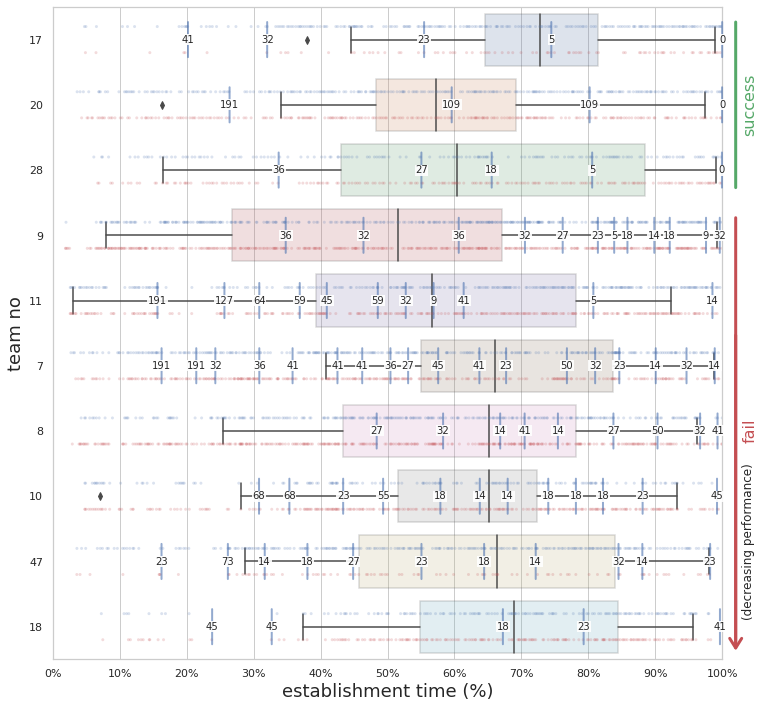

In [21]:
order = perf_order
seps = perf_seps

figsize = (12, 12)
fig, ax = plt.subplots(figsize=figsize)

# Plot utterances by marking their end times.
palette = sns.color_palette()
colors = list(palette)
cs = [colors[0], colors[3]]
df = all_corpus_df.copy()
# Filter for the utterances.
df = df[df.utterance_no != -1]
df = df[df.subject.isin(['A', 'B'])]
sns.stripplot(x='scaled_end', y='team_no', hue='subject',
              order=order, jitter=0,
              data=df, ax=ax, palette=cs, size=3,
              dodge=True, alpha=0.2)

# Annotate the submission costs on the plot.
for team_no, _ in routine_dfs.items():
    df = all_corpus_df.copy()
    df = df[df.team_no == str(team_no)]
    df = df[df.subject == 'T']
    y = order.index(str(team_no))

    for i, row in df.iterrows():
        arrow_start, arrow_end = 0, 0
        text_pos = row['scaled_end']

        val = row['error']
        s = '{:2.0%}'.format(val).strip('%')
        offset = 0
        props = dict(arrowstyle='-', alpha=0.6, linewidth=2, color='b')
        ax.annotate(s='',
                    xy=(text_pos, y+0.3),
                    xytext=(text_pos, y-0.3),
                    xycoords='data',
                    color='green', arrowprops=props)
        t = ax.annotate(s,
                        xy=(text_pos, y+offset),
                        backgroundcolor='w',
                        fontsize=10,
                        xycoords='data',
                        ha='center', va='center')
        t.set_bbox(dict(fc='w', alpha=0.9, ec='none',
                        boxstyle='square,pad=0.05'))
        
# Plot the establishment box plots.
x, xlabel = 'scaled_establish_time', 'establishment time (%)'
fig, ax = plot_establishment(
    all_routines_df, x=x, xlabel=xlabel,
    seps=seps, order=order,
    fig=fig, ax=ax)

## H1.2: When (a) task specific referents become routine and (b) their routines are primed, they are more likely to be surrounded by hesitation phenomena for more successful teams.

### Report filler counts.

In [22]:
fillers = ['um', 'uh', 'hmm', 'ahh', 'oops', 'eww'] # 'mm-hmm', 'uh-uh'
fillers

['um', 'uh', 'hmm', 'ahh', 'oops', 'eww']

In [23]:
for team_no, df in corpus_dfs.items():
    df['n_fillers'] = df.object.apply(lambda x: len([t for t in x.split() if t in fillers]))

In [24]:
for filler in fillers:
    counts = list()
    for team_no, df in corpus_dfs.items():
        df = df[df.subject.isin(['A', 'B'])]
        count = sum(df.object.apply(lambda x: len(
            [t for t in x.split() if t == filler])))
        counts.append(count)

    print(filler, np.sum(counts), np.mean(counts), np.std(counts))

um 236 23.6 13.514436725220923
uh 173 17.3 9.685556256612212
hmm 3 0.3 0.9000000000000001
ahh 4 0.4 0.66332495807108
oops 4 0.4 0.66332495807108
eww 1 0.1 0.30000000000000004


### Inspect filler distributions.

#### Make a fillers timing table.

In [25]:
# def make_with_fillers_table(contexts_df, transcript_df):
#     with_fillers_df = transcript_df.copy()
#     with_fillers_df.set_index('utterance_index', inplace=True)
#     with_fillers_df['n_contexts'] = 0

#     for i, row in contexts_df.iterrows():  # for each context
#         start = row['start']
#         end = row['end']
#         # print(start, end, len(with_fillers_df))
#         with_fillers_df.loc[start:end+1, 'n_contexts'] += 1 # increments context counts
        
#     with_fillers_df = with_fillers_df[with_fillers_df.n_fillers > 0].copy()
#     return with_fillers_df


# # for max_dist, dfs in context_dfs.items():
# with_fillers_dfs = dict()
# # max_dist = 'max_3'
# # dfs = context_dfs[max_dist]

# for task_index, contexts_df in dfs.items():
#     transcript_df = transcript_dfs[task_index]
#     with_fillers_df = make_with_fillers_table(contexts_df, transcript_df)
    
#     with_fillers_dfs[task_index] = with_fillers_df
# #     break

In [26]:
# all_with_fillers_df = pd.concat([with_fillers_dfs[k] for k in sorted(with_fillers_dfs)], ignore_index=True)
# # all_with_fillers_df
# all_with_fillers_df['context relation'] = ['in context' if n_contexts> 0 else 'free' for n_contexts in all_with_fillers_df['n_contexts']]

# #  palette="Paired", hue_order=["small", "big"]

### Perform Mann-Whitney U test and compute Cliff's delta

#### for establishment

In [27]:
# df = corpus_dfs[team_no]
# filler_df = df[df.n_fillers > 0].copy()
# filler_df

In [28]:
def check_effect_size(routine_col, filler_col, verbose=True):  # False):
    for team_no in learn_df.T.sort_values('learn (%)').index:
        routine_df = routine_dfs[team_no].copy()

        # filter for the fillers of this task.
        df = corpus_dfs[team_no].copy()
        df = df[df.subject.isin(['A', 'B'])]
        filler_df = df[df.n_fillers > 0]

        shared_vals = routine_df[routine_col].values
        filler_vals = filler_df[filler_col].values

        x = filler_vals
        y = shared_vals

        u, pvalue = scipy.stats.mannwhitneyu(x=x, y=y)
        thres = 0.05
        if pvalue < thres:
            ps = 'p < ' + '{:.2f}'.format(thres).lstrip('0')
        else:
            ps = 'p = ' + '{:.2f}'.format(pvalue).lstrip('0')

        d, size = cliffsDelta.cliffsDelta(x, y)
        if verbose:
            print('For Team {:02d}: '.format(team_no), end='')
            s = '$U = {:6.1f}$, ${}$'.format(u, ps)
            s += r", $\text{Cliff's delta}"
            s += " = {:.2f}$".format(d).lstrip('0')
            s += r' \\'
            print(s)
        
#         return routine_df, filler_df
#         break
    
print("U is the Mann–Whitney U test statistic, where p \< 0.05 indicates that the groups are statistically significantly different")
print("Cliff's delta \> 0 indicates filler times (or equivalently utterance positions) larger than establishment times. \< otherwise.")
print('filler positions vs.\ establishment positions (sorted by increasing learning):')
routine_col, filler_col = 'scaled_establish_no', 'scaled_utterance_no'
# # or equivalently in terms of times
# routine_col, filler_col = 'scaled_establish_time', 'scaled_end'
check_effect_size(routine_col, filler_col)

U is the Mann–Whitney U test statistic, where p \< 0.05 indicates that the groups are statistically significantly different
Cliff's delta \> 0 indicates filler times (or equivalently utterance positions) larger than establishment times. \< otherwise.
filler positions vs.\ establishment positions (sorted by increasing learning):
For Team 18: $U = 1331.5$, $p = .18$, $\text{Cliff's delta} = -0.10$ \\
For Team 20: $U = 1146.0$, $p < .05$, $\text{Cliff's delta} = -0.24$ \\
For Team 47: $U = 1536.0$, $p < .05$, $\text{Cliff's delta} = -0.23$ \\
For Team 08: $U =  461.5$, $p < .05$, $\text{Cliff's delta} = -0.43$ \\
For Team 28: $U =  832.0$, $p < .05$, $\text{Cliff's delta} = -0.22$ \\
For Team 07: $U =  229.0$, $p < .05$, $\text{Cliff's delta} = -0.68$ \\
For Team 09: $U = 3809.0$, $p < .05$, $\text{Cliff's delta} = 0.23$ \\
For Team 17: $U =  379.5$, $p < .05$, $\text{Cliff's delta} = -0.26$ \\
For Team 10: $U =  637.5$, $p = .45$, $\text{Cliff's delta} = 0.02$ \\
For Team 11: $U =  825.0

In [29]:
# shared_vals = routine_df[routine_col].values
# filler_vals = filler_df[filler_col].values
# shared_vals[0:5], filler_vals[0:5]
# routine_col, filler_col = 'scaled_establish_time', 'scaled_start'

In [30]:
# routine_col, filler_col = 'scaled_establish_no', 'scaled_utterance_no'
# check_effect_size(routine_col, filler_col)

# # routine_df, filler_df = check_effect_size(routine_col, filler_col)
# check_effect_size(routine_col, filler_col)

# shared_vals = routine_df[routine_col].values
# filler_vals = filler_df[filler_col].values
# shared_vals[0:5], filler_vals[0:5]

#### for priming

In [31]:
print('priming utterance times vs.\ filler utterance positions (sorted by increasing learning):')
routine_col, filler_col = 'scaled_priming_time', 'scaled_end'
# routine_col, filler_col = 'scaled_priming_no', 'scaled_utterance_no'
check_effect_size(routine_col, filler_col)

priming utterance times vs.\ filler utterance positions (sorted by increasing learning):
For Team 18: $U =  826.0$, $p < .05$, $\text{Cliff's delta} = 0.44$ \\
For Team 20: $U = 1255.0$, $p = .07$, $\text{Cliff's delta} = 0.17$ \\
For Team 47: $U =  944.5$, $p < .05$, $\text{Cliff's delta} = 0.53$ \\
For Team 08: $U =  723.5$, $p = .23$, $\text{Cliff's delta} = 0.10$ \\
For Team 28: $U =  555.5$, $p < .05$, $\text{Cliff's delta} = 0.48$ \\
For Team 07: $U =  487.0$, $p < .05$, $\text{Cliff's delta} = -0.31$ \\
For Team 09: $U = 1734.5$, $p < .05$, $\text{Cliff's delta} = 0.65$ \\
For Team 17: $U =  281.5$, $p < .05$, $\text{Cliff's delta} = 0.45$ \\
For Team 10: $U =  318.0$, $p < .05$, $\text{Cliff's delta} = 0.51$ \\
For Team 11: $U =  219.5$, $p < .05$, $\text{Cliff's delta} = 0.82$ \\
